# LaGrangian Optimization
Julian Hsu
25-Sept-2024

Let's just program up a LaGrangian optimization problem for fun.

In [75]:
import scipy.optimize as spo

import numpy as np
import pandas as pd

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  


## Let's start with an econ hw style example

In [76]:
def utility_linear(x):    
    return -1*(8*x[0] + 2*x[1])

def utility_cb(x):    
    return -1*(x[0]**(0.8) * x[1]**(0.2))


x1_price = 4
x2_price = 3
income = 20

def budget(x):
    return np.array(x[0]*x1_price + x[1]*x2_price- income)

print(utility_cb([1,1]))
print(utility_linear([1,1]))
print(budget([1,1]))

-1.0
-10
-13


In [77]:
xx=spo.minimize(fun=utility_cb, x0= np.ones(2),
                constraints= {'type': 'ineq', 'fun': lambda x:  income - x1_price*x[0] - x2_price*x[1]},
                bounds= ((0, None), (0, None)))

print( utility(xx.x) )
print( budget(xx.x) ) 

-34.66445111680889
7.069900220812997e-13


Show how utility changes as we increase the income.

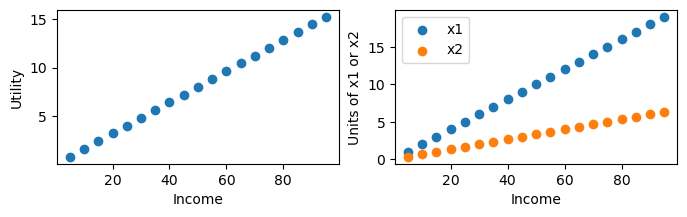

In [86]:
df_sim = pd.DataFrame()
for inc in np.arange(5,100,5):
    xx=spo.minimize(fun=utility_cb, x0= np.ones(2),
                    constraints= {'type': 'ineq', 'fun': lambda x:  inc - x1_price*x[0] - x2_price*x[1]},
                    bounds= ((0, None), (0, None)))
    output={'income':inc, 'utility':utility_cb(xx.x)*-1, 'x1':xx.x[0], 'x2':xx.x[1], 'spent':x1_price*xx.x[0] + x2_price*xx.x[1]}
    df_sim = pd.concat([df_sim, pd.DataFrame(index=[inc], data=output)])
fig,ax = plt.subplots(ncols=2, figsize=(8,2))
ax[0].scatter(df_sim['income'], df_sim['utility'])
ax[0].set_ylabel('Utility')
ax[0].set_xlabel('Income')

ax[1].scatter(df_sim['income'], df_sim['x1'], label='x1')
ax[1].scatter(df_sim['income'], df_sim['x2'], label='x2')
ax[1].set_ylabel('Units of x1 or x2')
ax[1].legend()
ax[1].set_xlabel('Income')
plt.show()


Now relative prices

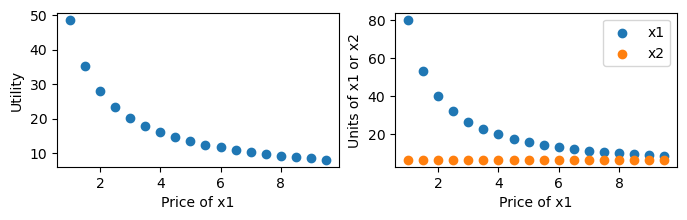

In [87]:
df_sim = pd.DataFrame()
for p1 in np.arange(1,10,0.5):
    xx=spo.minimize(fun=utility_cb, x0= np.ones(2),
                    constraints= {'type': 'ineq', 'fun': lambda x:  100 - p1*x[0] - x2_price*x[1]},
                    bounds= ((0, None), (0, None)))
    output={'income':100, 'utility':utility_cb(xx.x)*-1, 'x1':xx.x[0], 'x2':xx.x[1], 'price1':p1, 'spent':p1*xx.x[0] + x2_price*xx.x[1]}
    df_sim = pd.concat([df_sim, pd.DataFrame(index=[inc], data=output)])

fig,ax = plt.subplots(ncols=2, figsize=(8,2))
ax[0].scatter(df_sim['price1'], df_sim['utility'])
ax[0].set_ylabel('Utility')
ax[0].set_xlabel('Price of x1')

ax[1].scatter(df_sim['price1'], df_sim['x1'], label='x1')
ax[1].scatter(df_sim['price1'], df_sim['x2'], label='x2')
ax[1].set_ylabel('Units of x1 or x2')
ax[1].legend()
ax[1].set_xlabel('Price of x1')
plt.show()


Test whether we can solve for the lambda multiplier two ways:
1. Indirectly solve for lambda by first solving the problem with repect to the all other inputs except lambda, and plug them into the FOC wrt to other parameters:
$$\frac{\partial U}{\partial x_j} - \lambda p_j = 0, \text{  for j inputs}$$

2. Directly solve for the lambda multiplier by solving a system of equations that includes a first order condition taking the derivative with respect to utility parameters.

In [262]:
from scipy.optimize import approx_fprime
from scipy.optimize._numdiff import approx_derivative

def expression_for_lambda(x):
    foc1 = lambda x1: utility_cb([x1, x[1]])
    foc2 = lambda x2: utility_cb([x[0], x2])
    foc_array = approx_fprime(x[0], foc1), approx_fprime(x[1],foc2)

## 1. Indirectly solve for lambda 
xx=spo.minimize(fun=utility_cb, x0= np.ones(2),
                constraints= {'type': 'ineq', 'fun': lambda x:  income - x1_price*x[0] - x2_price*x[1]},
                bounds= ((0, None), (0, None)))

def expression_for_lambda(x):
    foc1 = lambda x1: utility_cb([x1, x[1]])/(-1*x1_price)
    foc2 = lambda x2: utility_cb([x[0], x2])/(-1*x2_price)
    foc_array = approx_fprime(x[0], foc1), approx_fprime(x[1],foc2)
    return np.array( foc_array )
print('Approach 1: indirectly solving for lambda:')
print('x1 x2 from directly solving optimization wrt to x1,x2 = {0}'.format(xx.x))
print('lambda from indirectly solving = {0}'.format( np.average( expression_for_lambda(xx.x) ) ) )
print('utility = {0:5.2} and total left over after spending = {1:5.2f}'.format(utility_cb(xx.x),budget(xx.x) ))

## 2. Directly solve for lambda
def lagrange(x):
    return ( utility_cb(x[0:2]) - x[-1]* (100 - x1_price*x[0] - x2_price*x[1]) )

lagrange([1,2,3])
def lagrange_deriv(x):
    return approx_fprime(x, lagrange)

poe=spo.root(fun=lagrange_deriv , x0= [1,1,1], method='df-sane', options={'maxiter':200})

print('Approach 2: directly solving for lambda:')
print('x1 x2 from directly solving optimization wrt to x1,x2 = {0}'.format(poe.x[0:2]))
print('lambda from indirectly solving = {0}'.format(  poe.x[-1] ) )
print('utility = {0:5.2} and total left over after spending = {1:5.2f}'.format(utility_cb(poe.x[0:2]),budget(poe.x[0:2]) ))

Approach 1: indirectly solving for lambda:
x1 x2 from directly solving optimization wrt to x1,x2 = [3.99958458 1.33388722]
lambda from indirectly solving = 0.16052330657839775
utility =  -3.2 and total left over after spending =  0.00
Approach 2: directly solving for lambda:
x1 x2 from directly solving optimization wrt to x1,x2 = [19.99999261  6.66667649]
lambda from indirectly solving = 0.16054828969719764
utility = -1.6e+01 and total left over after spending = 80.00


C:\Users\tarob\AppData\Local\Temp\ipykernel_12728\3391132475.py:32: OptimizeWarning: Unknown solver options: maxiter
  poe=spo.root(fun=lagrange_deriv , x0= [1,1,1], method='df-sane', options={'maxiter':200})
C:\Users\tarob\AppData\Local\Temp\ipykernel_12728\1519769421.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return -1*(x[0]**(0.8) * x[1]**(0.2))


Conclude that it's easier to take the indirect route.

## Would this work for "real" data?

Consider an approach where we want to determine how many workers to train. For each worker, we know their output with and without training. We would ideally maximize total worker output. However, each worker may choose to leave the training. If too many workers leave the training and we want to minimize the amount of workers who leave the training.  




Generate a dataset of workers, output with and without training, and probability of leaving the training.

In [269]:
def gen_worker_data(N=1000, correlated_treatments=False):
    baseline_output = np.random.uniform(0,1,N)
    new_output_w_training = baseline_output + np.random.uniform(0,0.25,N)
    if correlated_treatments==True:
        latent_leave = new_output_w_training - np.mean(new_output_w_training) + np.random.normal(-2,1,N)
    else:
        latent_leave = np.random.normal(-2,1,N)        
    leave_trainign = np.exp(latent_leave) / (1+ np.exp(latent_leave))
    return pd.DataFrame(data={'y0':baseline_output, 'y1':new_output_w_training, 'leave':leave_trainign})

gen_worker_data(N=1000, correlated_treatments=False).describe()

,y0,y1,leave
count,1000.000000,1000.000000,1000.000000
mean,0.506188,0.631899,0.151968
std,0.282272,0.291613,0.121542
min,0.005240,0.029308,0.006453
25%,0.271746,0.401038,0.063986
50%,0.512335,0.635898,0.114296
75%,0.747731,0.867580,0.206260
max,0.999549,1.243420,0.673839
